# Adventureworks försäljningsanalys

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

user = "SA"
password = quote_plus("Lejonkatt123!")
server = 'localhost:1434'
database = 'AdventureWorks2025'
driver = quote_plus("ODBC Driver 18 for SQL server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

Anslutning till SQL Server lyckades


C:\Users\shara\AppData\Local\Temp\ipykernel_6732\2280885530.py:23: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


In [2]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)
    

In [20]:
def format_number(value):
    if value >= 1_000_000:
        return f'{value/1_000_000:.1f} M'
    elif value >= 1_000:
        return f'{value/1_000:.1f} K'
    else: 
        return f'{int(value)}' 

def autolabel(ax, values, width=0.35, offset=0):
    for i, value in enumerate(values):
        if value > 0:  # Skippa om värdet är 0 eller saknas
            ax.text(
                i + offset,           # x-position: mitten av stapeln om offset=0
                value + 1,            # y-position: lite ovanför stapeln 
                format_number(value), # text ovanför stapel, avrundar med funktion
                ha='center',
                va='bottom',
                fontsize=10,
                fontweight='medium'
            )


## Analys 1 - Antal produkter per kategori
**Affärsfråga: Hur många produkter finns i varje kategori?**

Tabeller som används: Production.ProductCategory, Production.ProductSubcategory, Production.Product

**Plan**
1. JOINA tabellerna för att hämta Kategorinamn och räkna antal unika ProductID inom varje kategori
2. Göra om min Query till en Dataframe
3. Visualisera resultatet med vertikalt stapeldiagram med etiketter ovanför varje stapel
4. Analysera resultatet - Krav på insikt: **Förklara vilken kategori som har flest/minst produkter.**

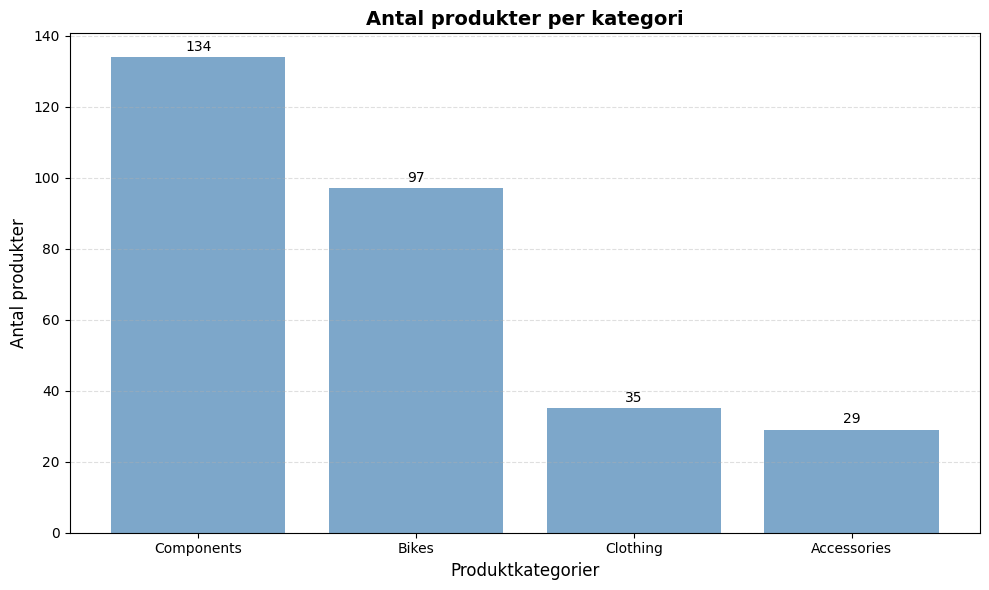

In [21]:
query_vis1 = """
SELECT
    pc.Name AS CategoryName,
    COUNT(DISTINCT p.ProductID) AS ProductCount
FROM Production.ProductCategory pc 
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC
"""

df_vis1 = query_df(query_vis1)

fig, ax = plt.subplots(figsize=(10,6))
bars = ax.bar(df_vis1['CategoryName'], df_vis1['ProductCount'], color='steelblue', alpha=0.7)

autolabel(ax, df_vis1['ProductCount'])
# for bar in bars:
#     height = bar.get_height()
#     ax.text(
#         bar.get_x() + bar.get_width()/2,
#         height,
#         f'{int(height)}',
#         ha = 'center',
#         va = 'bottom',
#         fontsize=11
#     ) 

ax.set_title('Antal produkter per kategori', fontsize=14, fontweight='bold')
ax.set_xlabel('Produktkategorier',fontsize=12)
ax.set_ylabel('Antal produkter', fontsize=12 )
ax.grid(axis='y',linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


### Insikter - Antal produkter per kategori
Resultatet visar att **Components** har flest produkter (134). Detta tyder på att Adventure Works har ett brett sortiment av komponenter, vilket är rimligt för ett cykelföretag där delar som ramar, pedaler och andra komponenter är viktiga för både anpassning och underhåll av cyklar. Det kan även indikera ett tydligt fokus på reparationer och uppgraderingar, vilket i sin tur kan bidra till återkommande försäljning.

Kategorin **Accessories** har istället det minsta antalet produkter (29) vilket antyder att tillbehör som exempelvis hjälmar inte är ett lika prioriterat område. Genom att bredda sortimentet inom både kläder och accessoarer skulle företaget kunna skapa bättre möjligheter till merförsäljning och kompletterande köp.

## Analys 2 - Försäljning per produktkategori
**Affärsfråga: Vilka produktkategorier genererar mest intäkter?**

Tabeller som används: Production.ProductCategory, Production.ProductSubcategory, Production.Product, Sales.SalesOrderDetail

**Plan**
1. JOINA tabellerna för att hämta Kategorinamn och räkna ut totalsumman av ordrar inom varje kategori
2. Göra om min Query till en Dataframe
3. Visualisera resultatet med horisontellt stapeldiagram, sortera från högst till lägst (högsta överst)
4. Skriva ut största och minsta kategori med exakta siffror då detta är en del av kravet
5. Analysera resultatet - Krav på insikt: **Förklara vilken kategori som är störst och minst, med exakta siffror.**

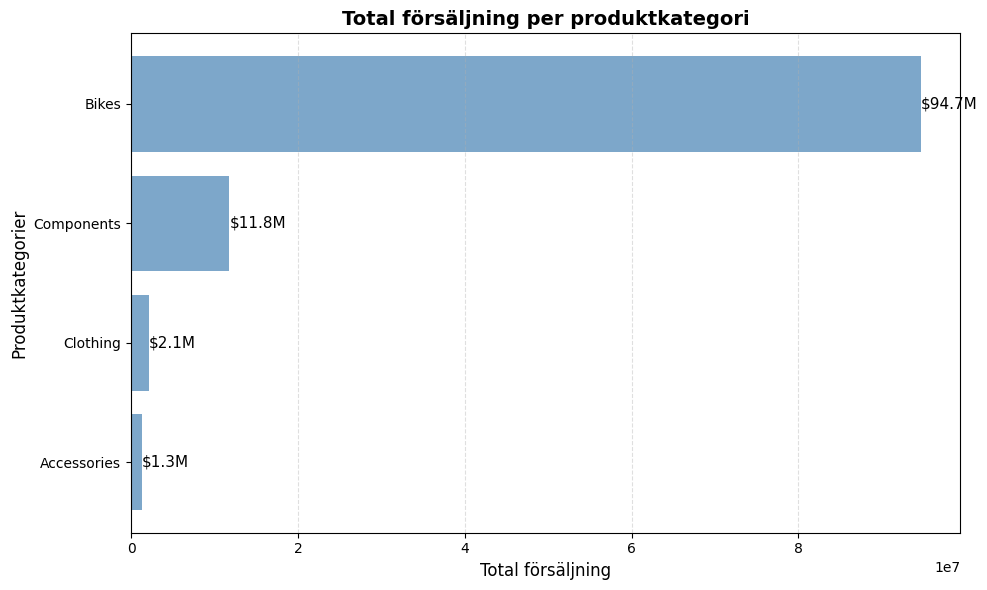

Största kategori: Bikes med totala försäljningen: $ 94,651,172.704731
Minsta kategori: Accessories med totala försäljningen: $ 1,272,072.883926


In [18]:
query_vis2 = """
SELECT
    pc.Name AS CategoryName,
    SUM(sod.LineTotal) AS TotalSales
FROM Production.ProductCategory pc 
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
INNER JOIN Sales.SalesOrderDetail sod ON p.ProductID = sod.ProductID 
GROUP BY pc.Name
ORDER BY TotalSales DESC 
"""

df_vis2 = query_df(query_vis2)

fig, ax = plt.subplots(figsize=(10,6))
bars = ax.barh(df_vis2['CategoryName'][::-1], df_vis2['TotalSales'][::-1], color='steelblue', alpha=0.7)

for bar in bars:
    width = bar.get_width()
    ax.text(
        width +1,
        bar.get_y() + bar.get_height()/2,
         f'${width/1_000_000:.1f}M',
        va = 'center',
        ha = 'left',
        fontsize=11
    ) 

ax.set_title('Total försäljning per produktkategori', fontsize=14, fontweight='bold')
ax.set_xlabel('Total försäljning',fontsize=12)
ax.set_ylabel('Produktkategorier', fontsize=12 )
ax.grid(axis='x',linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

print(f"Största kategori: {df_vis2.iloc[0]['CategoryName']} med totala försäljningen: $ {df_vis2.iloc[0]['TotalSales']:,}")
print(f"Minsta kategori: {df_vis2.iloc[-1]['CategoryName']} med totala försäljningen: $ {df_vis2.iloc[-1]['TotalSales']:,}")


### Insikter - Försäljning per produktkategori
Den klart strörsta produktkategorin är **Bikes** med en total försäljning på ca **$94,7 M**.   
Detta visar att cykelförsäljningen är kärnan i AdventureWorks verksamhet och den främsta intäktskällan.  
Samtidigt innebär det att företaget är relativt beroende av denna kategori, vilket gör att förändringar i efterfrågan på cyklar – exempelvis på grund av säsong eller konkurrens – kan få stor påverkan på det totala resultatet.

Den kategorin som genererar minst i försäljning är **Accessories** med en total omstättning på ca **$1,3 M**. Detta indikerar att tillbehör i nuläget utgör en mycket liten andel av företagets totala intäkter. Det kan även ses som en potentiell utvecklingsmöjlighet, där ett bredare sortiment eller ökad marknadsföring skulle kunna bidra till högre försäljning inom denna kategori.  




## Analys 3 - Försäljningstrend över tid
**Affärsfråga: Hur har försäljningen utvecklats över tid?**

Tabeller som används: Sales.SalesOrderHeader

**Plan**
1. Formatera om 'Orderdate' så det går att gruppera på månad samt summera totalförsäljning
2. Göra om min Query till en Dataframe
3. Visualisera resultatet med linjediagram
4. Skriv ut månaderna med största/minsta totala försäljning
5. Visualisera med ytterligre ett linjediagram för att göra säsongsaspekterna tydligare
5. Analysera resultatet - Krav på insikt: **Beskriv trenden - ökar den, minskar den, är den säsongsberoende? Nämn högsta och lägsta månaden.**

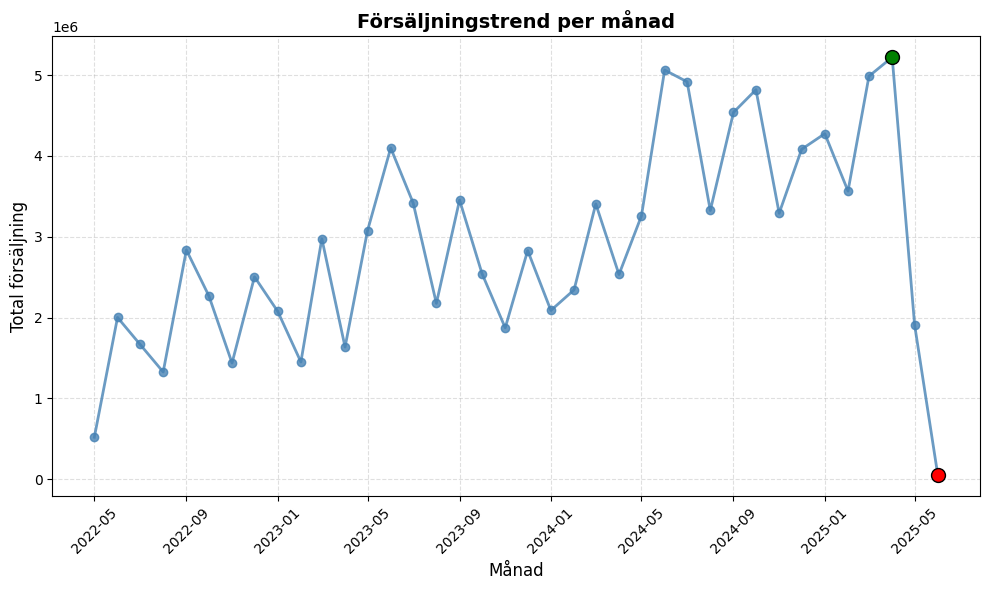

Högsta försäljningen inträffade: April-2025 med totala försäljningen: $ 5,222,759
Minsta försäljningen inträffade: June-2025 med totala försäljningen: $ 47,492


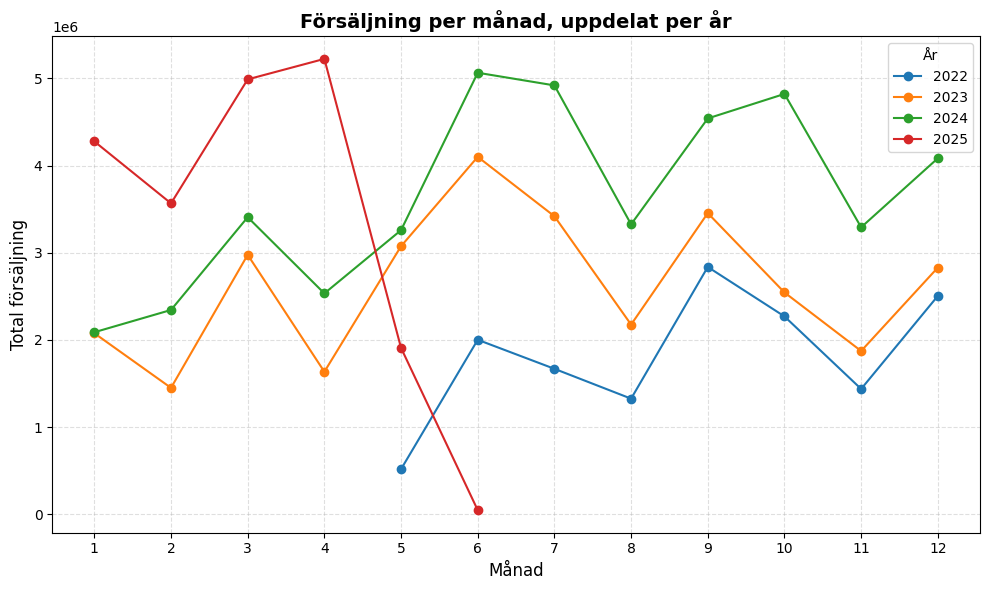

In [6]:
query_vis3 = """
SELECT
    DATEFROMPARTS(YEAR(OrderDate), MONTH(OrderDate), 1) AS YearMonth,
    SUM(SubTotal) AS TotalSales
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate), MONTH(OrderDate)
ORDER BY YearMonth
"""

df_vis3 = query_df(query_vis3)
max_row = df_vis3.loc[df_vis3['TotalSales'].idxmax()]
min_row = df_vis3.loc[df_vis3['TotalSales'].idxmin()]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(df_vis3['YearMonth'], df_vis3['TotalSales'], color='steelblue', linewidth=2, marker='o',alpha=0.8)
ax.scatter(max_row['YearMonth'], max_row['TotalSales'], color='green', edgecolors='black', s=100, zorder=5)
ax.scatter(min_row['YearMonth'], min_row['TotalSales'], color='red', edgecolors='black', s=100, zorder=5)
ax.set_title('Försäljningstrend per månad', fontsize=14, fontweight='bold')
ax.set_xlabel('Månad',fontsize=12)
ax.set_ylabel('Total försäljning', fontsize=12 )
ax.grid(True,linestyle='--', alpha=0.4)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Högsta försäljningen inträffade: {max_row['YearMonth'].strftime('%B-%Y')} med totala försäljningen: $ {max_row['TotalSales']:,.0f}")
print(f"Minsta försäljningen inträffade: {min_row['YearMonth'].strftime('%B-%Y')} med totala försäljningen: $ {min_row['TotalSales']:,.0f}")

# Graf som visar år/säsongstrender tydligare
df_vis3['YearMonth'] = pd.to_datetime(df_vis3['YearMonth'])
df_vis3['Year'] = df_vis3['YearMonth'].dt.year
df_vis3['Month'] = df_vis3['YearMonth'].dt.month

fig, ax = plt.subplots(figsize=(10,6))
for year in sorted(df_vis3['Year'].unique()):
    df_year = df_vis3[df_vis3['Year'] == year]
    ax.plot(
        df_year['Month'],
        df_year['TotalSales'],
        marker='o',
        label=str(year)
    )

ax.set_title("Försäljning per månad, uppdelat per år", fontsize=14, fontweight='bold')
ax.set_xlabel("Månad", fontsize=12)
ax.set_ylabel("Total försäljning", fontsize=12)
ax.set_xticks(range(1,13))  # 1-12 månader
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(title='År')
plt.tight_layout()
plt.show()


### Insikter - Försäljningstrend över tid
**Övergripande trend**  
Försäljningen visar en tydlig **stigande** trend över perioden från mitten av 2022 till början av 2025. Det innebär att AdventureWorks har ökat sin försäljning över tid, vilket är positivt för företagets utveckling.

**Säsongsvariationer**  
I båda graferna syns tydliga **säsongsmönster** med regelbundna toppar och dalar under varje år.
Vanligtvis är det högre försäljning under vår/sommar och i slutet av året – troligen kopplat till vädersäsong + julhandel.

**Högsta och lägsta månad**  
Högsta försäljningen inträffade i början av 2025 (markerad med grön punkt i första grafen), med över 5 miljoner dollar i försäljning.
Lägsta försäljningen skedde i mitten av 2025 (markerad med röd punkt), med en försäljning på endast ca 47 000 dollar. (Vilket kan beror på att datan där är ofullständig.)

**Observationer/avvikelser**  
Den plötsliga "kollapsen" 2025 är alarmerande och avviker helt från tidigare mönster. Detta kan indikera externa faktorer (t.ex. lågkonjektur, leveransproblem) eller interna problem (t.ex datakvalitetsfel) För att kunna analysera datan vidare behövs ytterligare en utredning.

## Analys 4 - Försäljning och antal ordrar per år
**Affärsfråga: Hur ser total försäljning och antal ordrar ut per år?**

Tabeller som används: Sales.SalesOrderHeader

**Plan**
1. Formatera om 'Orderdate' så det går att gruppera på år samt summera totalförsäljning och räkna unika ordrar.
2. Göra om min Query till en Dataframe
3. Visualisera resultatet med grupperat stapeldiagram
4. Analysera resultatet - Krav på insikt: **Jämför åren - vilket år hade högst försäljning? Ökar både försäljning OCH antal ordrar, eller bara det ena?.**

,OrderYear,TotalOrder,TotalSales
0,2022,1692,"14,561,052"
1,2023,3830,"31,604,922"
2,2024,14244,"43,671,890"
3,2025,11699,"20,008,518"


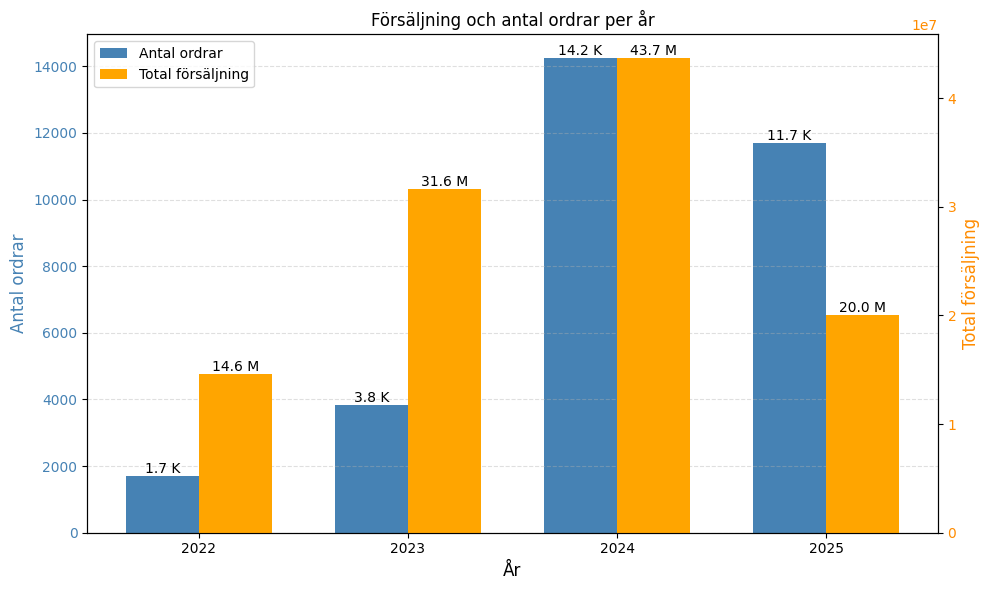

In [22]:
query_vis4 = """
SELECT
    YEAR(OrderDate) AS OrderYear,
    COUNT(DISTINCT SalesOrderID) AS TotalOrder,
    SUM(SubTotal) AS TotalSales
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate)
ORDER BY OrderYear
"""

df_vis4 = query_df(query_vis4)
df_vis4_display = df_vis4.copy()
df_vis4_display['TotalSales'] = df_vis4_display['TotalSales'].round(0).astype(int).map('{:,.0f}'.format)
display(df_vis4_display)

# Data
years = df_vis4['OrderYear']
orders = df_vis4['TotalOrder']
sales = df_vis4['TotalSales']

# Positioner för grupperade staplar
x = np.arange(len(years))
width = 0.35

# Skapa diagram med två y-axlar (olika skalor)
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.bar(x - width/2, orders, width, label='Antal ordrar', color='steelblue')
ax1.set_xlabel('År', fontsize=12)
ax1.set_ylabel('Antal ordrar', color='steelblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.set_xticks(x)
ax1.set_xticklabels(years)
ax1.grid(axis='y', linestyle='--', alpha=0.4)

ax2 = ax1.twinx()
ax2.bar(x + width/2, sales, width, label='Total försäljning', color='orange')
ax2.set_ylabel('Total försäljning', color='darkorange', fontsize=12)
ax2.tick_params(axis='y', labelcolor='darkorange')

autolabel(ax1, orders, width=0.35, offset=-width/2)
autolabel(ax2, sales, width=0.35, offset=+width/2)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.title('Försäljning och antal ordrar per år')
plt.tight_layout()
plt.show()




### Insikter - Försäljning och antal ordrar per år

Diagrammet visar utvecklingen av både antal ordrar och total försäljning per år.
Både försäljning och antal ordrar ökar från 2022 till 2024, vilket indikerar en
tydlig tillväxtperiod för AdventureWorks.

År 2024 sticker ut som det starkaste året med både högst antal ordrar och högst
total försäljning. Under 2025 syns däremot en minskning i både försäljning och
antal ordrar jämfört med 2024, vilket kan tyda på en avmattning eller att året
inte är komplett.

Försäljningen ökar proportionellt mer än antalet ordrar mellan 2022 och 2024,
vilket kan indikera att det genomsnittliga ordervärdet har ökat. Detta tyder på
att företaget inte bara säljer mer, utan även lyckas generera högre intäkter per
order.

---

## Analys 5 -  Top 10 produkter
**Affärsfråga:  Vilka 10 produkter genererar mest försäljning?**

Tabeller som används: Production.Product, Sales.SalesOrderDetail, Production.ProductSubcategory, Production.ProductCategory.

**Plan**
1. JOINA tabellerna för att räkna ut totala försäljningssumman per produkt samt ta fram kategorinamn. Sortera i decending för att visa "Top 10" bäst säljande produkter
2. Göra om min Query till en Dataframe
3. Visualisera resultatet med Horisontellt stapeldiagram
4. Skriva ut Nr 1 med exakt försäljningsvärde samt vilken kategori som dominerar top 10
4. Analysera resultatet - Krav på insikt: **Nämn #1 produkten med exakt försäljningsvärde. Vilken kategori dominerar topp 10?.**

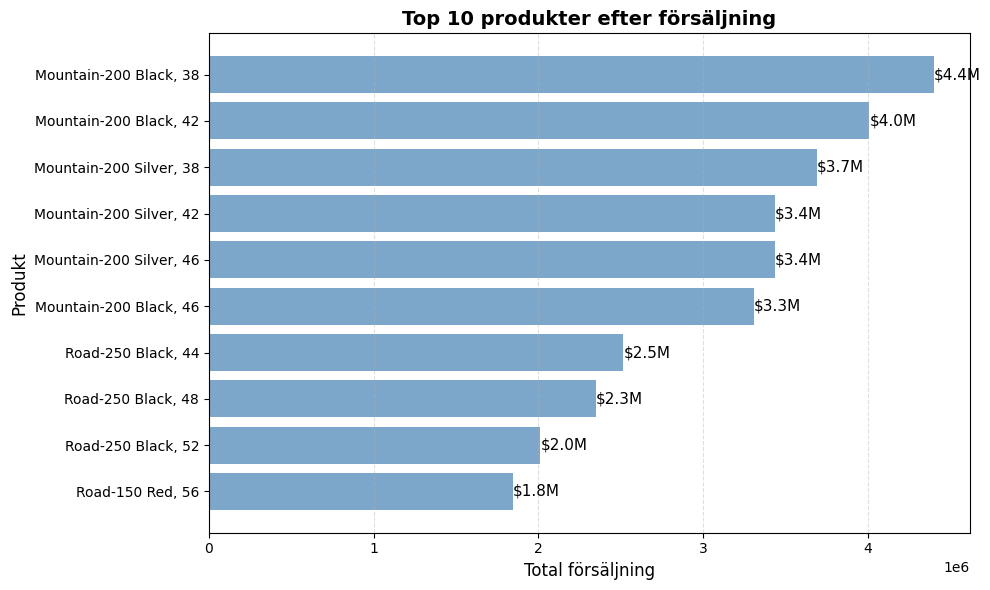

Produkten på plats 1 är: Mountain-200 Black, 38. Med en total försäljning på: $ 4,400,592.8004
Den Produktkategori som dominerar top 10 är: Bikes (10 av 10 produkter)


In [8]:
query_vis5 = """
SELECT
    TOP 10
    p.Name AS ProductName,
    SUM(sod.LineTotal) AS TotalSales,
    pc.Name AS CategoryName
FROM Production.Product p  
INNER JOIN Sales.SalesOrderDetail sod ON p.ProductID = sod.ProductID
INNER JOIN Production.ProductSubcategory ps ON p.ProductSubcategoryID = ps.ProductSubcategoryID
INNER JOIN Production.ProductCategory pc ON ps.ProductCategoryID = pc.ProductCategoryID
GROUP BY p.ProductID, p.Name, pc.Name
ORDER BY TotalSales DESC
"""

df_vis5 = query_df(query_vis5)


fig, ax = plt.subplots(figsize=(10,6))
bars = ax.barh(df_vis5['ProductName'][::-1], df_vis5['TotalSales'][::-1], color='steelblue', alpha=0.7)

for bar in bars:
    width = bar.get_width()
    ax.text(
        width +1,
        bar.get_y() + bar.get_height()/2,
        f'${width/1_000_000:.1f}M',
        va = 'center',
        ha = 'left',
        fontsize=11
    ) 

ax.set_title('Top 10 produkter efter försäljning', fontsize=14, fontweight='bold')
ax.set_xlabel('Total försäljning',fontsize=12)
ax.set_ylabel('Produkt', fontsize=12 )
ax.grid(axis='x',linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

dominant_category = df_vis5['CategoryName'].value_counts().idxmax()
count = df_vis5['CategoryName'].value_counts().max()

print(f"Produkten på plats 1 är: {df_vis5.iloc[0]['ProductName']}. Med en total försäljning på: $ {df_vis5.iloc[0]['TotalSales']:,}")
print(f'Den Produktkategori som dominerar top 10 är: {dominant_category} ({count} av 10 produkter)')


### Insikter - Top 10 produkter

De 10 produkter som genererar mest försäljning är samtliga cyklar från kategorin **Bikes**, vilket tydligt visar att denna kategori är företagets absolut starkaste försäljningsområde.

- **Produkten på plats 1** är **Mountain-200 Black, 38** med en total försäljning ca **$ 4,4 miljoner**.  
  Den står ensam för över 10 % av den sammanlagda försäljningen från hela topp 10-listan. 

- Topp 10 domineras fullständigt av kategorin **Bikes** (100 % av produkterna).  
  Modellerna **Mountain-200** (6 av 10 platser) genererar tillsammans över 70% av topp 10-försäljningen.

**Sammanfattningsvis** visar analysen att **Mountain-200** är den ledande produktserien i AdventureWorks, både vad gäller antal produkter i toppskiktet och försäljningsvolym. Detta är värdefull information för affärsbeslut som rör lagerhantering, marknadsföring och produktutveckling.

Samtidigt innebär den starka koncentrationen till en enda modellfamilj en potentiell risk. Om det uppstår leveransproblem, kvalitetsbrister, ökad konkurrens eller förändrade kundpreferenser kring just denna serie kan det påverka företagets totala försäljning betydligt.

---

## Analys 6 - Försäljning och antal kunder per region
**Affärsfråga: Hur skiljer sig försäljningen mellan olika regioner, och hur många unika kunder har varje region?**

Tabeller som används: Sales.SalesTerritory, Sales.SalesOrderHeader, Sales.Customer

**Plan**
1. JOINA tabellerna för att hämta Regionsnamn och räkna ut totalsumman för varje region. Samt räkna antal unika CustomerID inom varje region
2. Göra om min Query till en Dataframe
3. Visualisera resultatet med Grupperat stapeldiagram
4. Analysera resultatet - Krav på insikt: **Vilken region är starkast/svagast? Jämför: Har regionen med högst försäljning också flest kunder, eller har de färre kunder med högre ordervärde? Vad betyder det?.**

,RegionName,TotalSales,TotalCustomers
0,Southwest,"24,184,610",4565
1,Canada,"16,355,770",1677
2,Northwest,"16,084,943",3428
3,Australia,"10,655,336",3625
4,Central,"7,909,009",69
5,Southeast,"7,879,655",91
6,United Kingdom,"7,670,721",1951
7,France,"7,251,556",1844
8,Northeast,"6,939,374",57
9,Germany,"4,915,408",1812


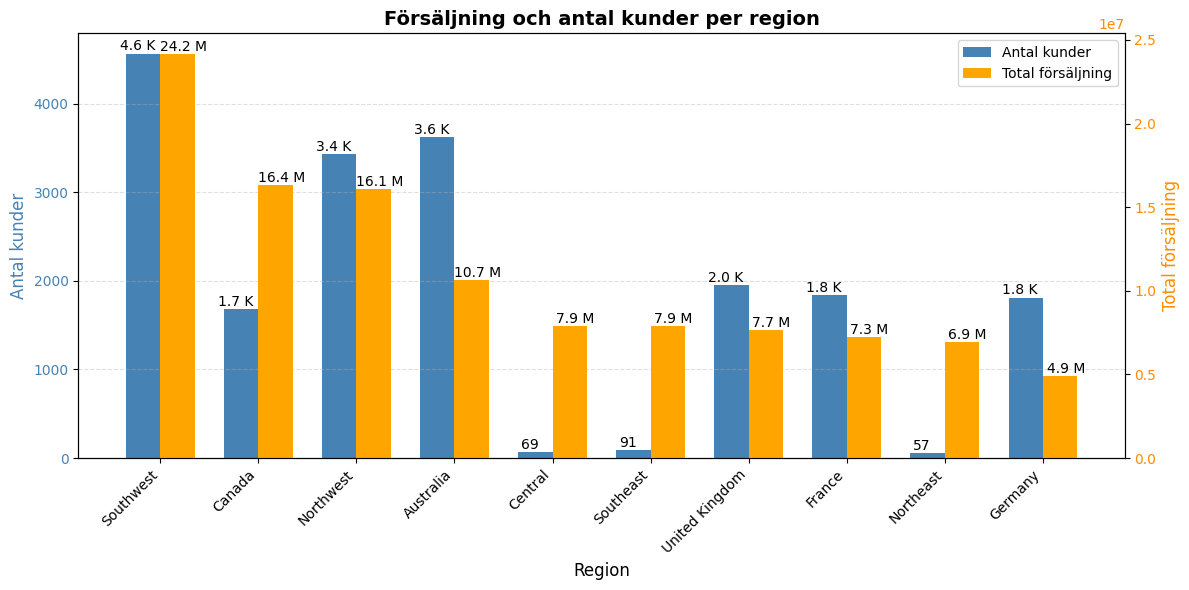

In [30]:
query_vis6 = """
SELECT
    st.Name AS RegionName,
    SUM(soh.SubTotal) AS TotalSales,
    COUNT(DISTINCT c.CustomerID) AS TotalCustomers
FROM Sales.SalesTerritory st
INNER JOIN Sales.Customer c ON st.TerritoryID = c.TerritoryID
INNER JOIN Sales.SalesOrderHeader soh ON c.CustomerID = soh.CustomerID
GROUP BY st.Name
ORDER BY TotalSales DESC
"""

df_vis6 = query_df(query_vis6)

df_vis6_display = df_vis6.copy()
df_vis6_display['TotalSales'] = df_vis6_display['TotalSales'].round(0).astype(int).map('{:,.0f}'.format)
display(df_vis6_display)

# Data
regions = df_vis6['RegionName']
customers = df_vis6['TotalCustomers']
sales = df_vis6['TotalSales']

# Positioner för grupperade staplar
x = np.arange(len(regions))
width = 0.35

# Skapa diagram med två y-axlar (olika skalor)
fig, ax1 = plt.subplots(figsize=(12,6))

# Stapel - Antal kunder (vänster axel)
ax1.bar(x - width/2, customers, width, label='Antal kunder', color='steelblue')
ax1.set_xlabel('Region', fontsize=12)
ax1.set_ylabel('Antal kunder', color='steelblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.set_xticks(x)
ax1.set_xticklabels(regions, rotation=45, ha='right')
ax1.grid(axis='y', linestyle='--', alpha=0.4)

# Stapel för total försäljning (höger axel)
ax2 = ax1.twinx()
ax2.bar(x + width/2, sales, width, label='Total försäljning', color='orange')
ax2.set_ylabel('Total försäljning', color='darkorange', fontsize=12)
ax2.tick_params(axis='y', labelcolor='darkorange')

autolabel(ax1, customers, width=0.35, offset=-width/1.5)
autolabel(ax2, sales, width=0.35, offset=+width/1.5)

# Legend – kombinerar båda axlarna
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')


plt.title('Försäljning och antal kunder per region', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()






### Insikter - Försäljning och antal kunder per region

Analysen visar tydliga skillnader mellan regionerna

**Starkaste regionen är Southwest**, med överlägset högst total försäljning (ca $24,2 miljoner) och samtidigt flest unika kunder (4 565). Detta indikerar en stark kombination av hög kundvolym och bra genomsnittligt ordervärde.
**Svagaste regionen är Germany**, med lägst försäljning (ca $4,9 miljoner), trots ett relativt högt antal kunder (1 812) – Detta tyder på ett lägre genomsnittligt ordervärde per kund jämfört med andra regioner.

Samtidigt finns regioner som Canada, Central, Southeast och Northeast som genererar hög försäljning trots få kunder, vilket indikerar högt genomsnittligt ordervärde och troligen större eller mer professionella kunder.

Sammantaget pekar analysen på behovet av olika strategier per region: kundvolym i starka marknader och fokus på kundvärde och kundlojalitet i regioner med färre men mer värdefulla kunder.

---

## Analys 7 - Genomsnittligt ordervärde per region och kundtyp
**Affärsfråga: Vilka regioner har högst/lägst genomsnittligt ordervärde, och skiljer det sig mellan individuella kunder och företagskunder?**


Tabeller som används: Sales.SalesTerritory, Sales.SalesOrderHeader, Sales.Customer

**Plan**
1. JOINA tabellerna för att hämta Regionsnamn, skapa en ny kolumn "CostumeTyp" genom att skapa en CASE som sorterar "Store" och "Person" med hjälp av "StoreID" samt räkna ut AVO för varje region. 
2. Göra om min Query till en Dataframe
3. Visualisera resultatet med Grupperat stapeldiagram
4. Analysera resultatet - Krav på insikt: **Vilken grupp har högre ordervärde? Skiljer det sig mellan regioner? Vad kan förklara skillnaderna? Vilken region + kundtyp-kombination har högst ordervärde?**

,RegionName,CustomType,TotalSales,OrderCount,AvgOrderValue
0,Australia,Store,1.594335e+06,125,12754.683003
1,Australia,Person,9.061001e+06,6718,1348.764600
2,Canada,Store,1.437793e+07,692,20777.349123
3,Canada,Person,1.977845e+06,3375,586.028107
4,Central,Store,7.906008e+06,376,21026.617491
5,Central,Person,3.000830e+03,9,333.425511
6,France,Store,4.607538e+06,188,24508.180495
7,France,Person,2.644018e+06,2484,1064.419370
8,Germany,Store,2.021095e+06,139,14540.253653
9,Germany,Person,2.894312e+06,2484,1165.182101


Index(['Southwest', 'France', 'Northwest', 'United Kingdom', 'Canada',
       'Central', 'Northeast', 'Southeast', 'Germany', 'Australia'],
      dtype='object', name='RegionName')

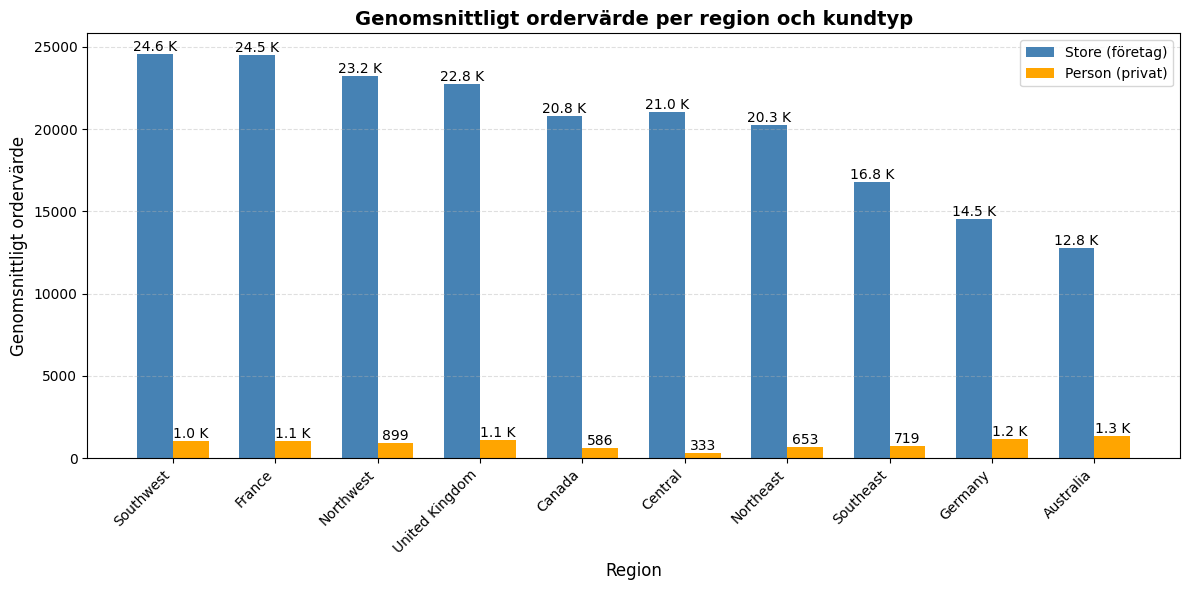

In [ ]:
query_vis7 = """
SELECT
    st.Name AS RegionName,
    CASE 
        WHEN c.StoreID IS NOT NULL THEN 'Store'
        ELSE 'Person'
    END AS CustomType,
    SUM(soh.SubTotal) AS TotalSales,
    COUNT(*) AS OrderCount
FROM Sales.SalesTerritory st  
INNER JOIN Sales.Customer c ON st.TerritoryID = c.TerritoryID
INNER JOIN Sales.SalesOrderHeader soh ON c.CustomerID = soh.CustomerID
GROUP BY st.Name, 
         CASE WHEN c.StoreID IS NOT NULL THEN 'Store' ELSE 'Person' END
ORDER BY st.Name, CustomType DESC
"""

df_vis7 = query_df(query_vis7)

# Skapa ny kolumn med avg för varje rad
df_vis7['AvgOrderValue'] = df_vis7['TotalSales'] / df_vis7['OrderCount']
display(df_vis7)

# Gruppera på region och sortera på totalt genomsnitt
region_order = (df_vis7.groupby('RegionName')['AvgOrderValue']
              .mean()
              .sort_values(ascending=False)
              .index
              )

# Dela upp "Store" och "Person" i separata DataFrames
df_store = df_vis7[df_vis7['CustomType'] == 'Store'].set_index('RegionName')
df_person = df_vis7[df_vis7['CustomType'] == 'Person'].set_index('RegionName')

# Data
regions = region_order                                      # x-axel
store_values = df_store.loc[regions]['AvgOrderValue']       # Stapel 1 "Store"
person_values = df_person.loc[regions]['AvgOrderValue']     # Stapel 2 "Person"

# Positioner för grupperade staplar
x = np.arange(len(regions))
width = 0.35

# Skapa diagram med två y-axlar (olika skalor)
fig, ax = plt.subplots(figsize=(12,6))

# Stapel 1 - Store
ax.bar(x - width/2, store_values, width, label='Store (företag)', color='steelblue')
# Stapel 2 - Person
ax.bar(x + width/2, person_values, width, label='Person (privat)', color='orange')

autolabel(ax, store_values, width=0.35, offset=-width/2)
autolabel(ax, person_values, width=0.35, offset=+width/2)

ax.set_xlabel('Region', fontsize=12)
ax.set_ylabel('Genomsnittligt ordervärde', fontsize=12)
ax.set_title('Genomsnittligt ordervärde per region och kundtyp',fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(regions, rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.4)
ax.legend()
plt.tight_layout()
plt.show()








### Insikter - Genomsnittligt ordervärde per region och kundtyp